# Multi-Scale Spiking Network Model of Human Cerebral Cortex

**Model overview**: The model comprises all 34 areas of the Desikan-Killiany parcellation in one hemisphere of human cerebral cortex. Each area is modeled by a column with $\mathrm{1\mathrm{mm^{2}}}$ cortical surface. Within each column, the full number of neurons and synapses based on anatomical data is included. In total, this leads to 3.47 million neurons and 42.8 billion synapses. Both the intrinsic and the cortico-cortical connectivity are layer- and population-specific.

<img src="./figures/model_overview.png" alt="Model overview" width="1000"/>

# Down-scaled human multi-area model

This code in this notebook implements the down-scaled version of the multi-scale, spiking network model of human cortex developed at the Institute of Advanced Simulation (IAS-6), Research Center Jülich. The model has been documented in the following publication:

- <a id="mainRef"></a>[1] Pronold, J., Meegen, A. van, Shimoura, R. O., Vollenbröker, H., Senden, M., Hilgetag, C. C., Bakker, R., & Albada, S. J. (2024). Multi-scale spiking network model of human cerebral cortex. Cerebral Cortex. [https://doi.org/10.1093/cercor/bhae409](https://doi.org/10.1093/cercor/bhae409).

## Notebook Outline <a class="anchor" id="toc"></a>
* [S0. Configuration](#section_0)
* [S1. Parameterization](#section_1)
    * [1.1. Parameters to tune](#section_1_1)
* [S2. Model Configuration, Instantiation and Simulation](#section_2)
    * [2.1. Configuring model parameters](#section_2_1)
    * [2.2. Instantiate a multi-area model](#section_2_2)
    * [2.3. Predict firing rates from theory](#section_2_3)
    * [2.4. Extract and visualize inter-areal connectivity](#section_2_3)
    * [2.5. Run a simulation](#section_2_5)
* [S3. Visualization of Network Dynamics](#section_3) 
    * [3.1. Mean firing rate over simulated populations](#section_3_1)
    * [3.2. Instantaneous firing rate over simulated areas](#section_3_2)
    * [3.3. Time-averaged firing rate over all populations](#section_3_3)
    * [3.4. Network dynamics](#section_3_4)
    * [3.5. Functional connectivity](#section_3_5)
* [Additional Notes](#section_4)

## S0. Configuration <a class="anchor" id="section_0"></a>

In [1]:
import os
import sys
import importlib.util

from copy import deepcopy

import humam

net_params = deepcopy(humam.network.default_params)
sim_params = deepcopy(humam.simulation.default_params)
ana_params = deepcopy(humam.analysis.default_params)

# Configure Matplotlib to render plots inline
%matplotlib inline


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Aug 27 2024 04:33:06

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



**Note**: if needed, additional python packages can be installed via `!pip install <package_name>` and then imported in this section.

In [2]:
# If using the Kernel EBRAINS-24.04, install the following missing packages. Otherwise, comment out the following line.
# !pip install dicthash nnmt

Go back to [Notebook Outline](#toc)

## S1. Parameterization <a class="anchor" id="section_1"></a>

### 1.1. Parameters to tune <a class="anchor" id="section_1_1"></a>

The values assigned for the following parameters are kept the same as in the paper except for the `scaling_factor`, which is set to 0.004 to enable the simulation of a down-scaled multi-area model with 2GB RAM. By default, it is set to 1.0 for simulating the full-scale model.

The `scaling_factor` scales the number of neurons and synapses. The code first calculates the full-scale values from the methods described in [[1]](https://doi.org/10.1093/cercor/bhae409), then these values are adjusted accordingly with the factor.

In [3]:
# Set scaling parameters
# value range/options: (0, 1.], change it to 1. to simulate the full-scale network
scaling_factor = 0.004

# Scaling factor for cortico-cortical connections (Chi_E) to excitatory neurons.
# Chi = 0.0 removes long-range cortico-cortical connections.
# Chi = 1.0 produces base version results in Pronold et al. (2024).
# Chi = 2.5 produces best fit version results in Pronold et al. (2024).
# obs: Chi to inhibitory neurons is set to 2.0 times the scaling factor for excitatory neurons.
net_params['cc_scalingEtoE'] = 1.0

**Note 1**: `cc_scalingEtoE` plays a crucial role in transitioning the network activity from the base to the best-fit version.  In the full-scale network, the base and best-fit versions activities are achieved when this parameter is set to `1.0` and `2.5`, respectively.

* Base version: In this configuration, the inter-areal synaptic strengths are equal to the local synaptic strengths, representing a baseline level of connectivity.
* Best-fit version: This configuration results in network activity that closely matches experimental data, achieved by increasing the inter-areal synaptic strengths relative to the local ones.

**Note 2**: When the network is downscaled, the code will increase synaptic weights to compensate for the reduced number of synapses. Additionally, a DC current is added based on predicted firing rates from the base version.

Go back to [Notebook Outline](#toc)

## S2. Model Configuration, Instantiation and Simulation <a class="anchor" id="section_2"></a>

### 2.1. Configuring model parameters <a class="anchor" id="section_2_1"></a>

We try our best not to confuse users with too many parameters. So, the few parameters tunned will be automatically assigned in this section to properly run the simulation. 

However, if you want to explore the model, you can alter other parameters related to the network or simulation configuration by passing them in the `net_params` and `sim_params` dictionaries below. If this is not the case, you can execute the cell the way it is.

In [4]:
# Get path to the output directory
net_params['outpath'] = os.path.join(
    os.getcwd(), 'out', 'downscaled'+str(scaling_factor)+'_cc'+str(net_params['cc_scalingEtoE'])
    )
outpath = net_params['outpath']

# Get base path
base_path = os.getcwd()

# Set the scaling factor for the number of neurons and synapses
net_params['N_scaling'] = scaling_factor
net_params['K_scaling'] = scaling_factor

# Mean fullscale firing rate to scale the firing rates of the neurons
net_params['fullscale_rates'] = './simulated_data/base_theory_rates.pkl'

# Scaling factor for cortico-cortical connections (Chi) to inhibitory neurons.
# it is set to 2.0 times the scaling factor for excitatory neurons.
# This keeps the stability of the network.
net_params['cc_scalingEtoI'] = net_params['cc_scalingEtoE']*2.0

# Set simulation parameters
sim_params['t_sim'] = 2000.0        # Simulation time in ms
sim_params['master_seed'] = 2903    # Seed for the random number generator
num_threads = int(4)                # Number of threads to use for the simulation 

# Set plotting parameters
ana_params['plotRasterArea']['low'] = 1600      # Lower bound of the area to plot the raster plot
ana_params['plotRasterArea']['high'] = 2000     # Upper bound of the area to plot the raster plot
ana_params['plotRasterArea']['fraction'] = 1.0  # Fraction of neurons to plot in the raster plot

Go back to [Notebook Outline](#toc)

### 2.2. Generate connectivity matrix and define neuron numbers <a class="anchor" id="section_2_2"></a>

In this section, we generate the connectivity matrix and define the neuron numbers for the down-scaled multi-area model of the human cerebral cortex. The `NeuronNumbers` class is used to calculate the number of neurons in the network based on the provided surface area and cytoarchitecture parameters. Similarly, the `SynapseNumbers` class calculates the number of synapses in the network using the neuron numbers and predictive connectomic parameters.

The `Network` class is then instantiated with the neuron and synapse numbers, and the network configuration is saved to the output directory. The network hash is also generated for further reference.


In [5]:
# Check if the network has already been created
if os.path.exists(os.path.join(outpath, 'network_hash.txt')):
	with open(os.path.join(outpath, 'network_hash.txt'), 'r') as f:
		net_hash = f.read()
else:
	# Create NeuroNumbers class
	# This class calculates the number of neurons in the network
	neuron_numbers = humam.NeuronNumbers(
		surface_area=net_params['surface_area'],
		**net_params['cytoarchitecture_params']
	)
	# Create SynapseNumbers class
	# This class calculates the number of synapses in the network
	synapse_numbers = humam.SynapseNumbers(
		NN=neuron_numbers,
		**net_params['predictive_connectomic_params']
	)

	# Get the number of neurons and synapses in the full-scale network for further reference
	fullscale_NN_SN = {
		'NN': neuron_numbers.getNeuronNumbers(),
		'SN': synapse_numbers.getSynapseNumbers()
	}

	# Create Network
	# This class prepares the network for simulation, including the initialization of the neurons and synapses
	# and the creation of the connectivity matrix. The scaling factors are applied here.
	net = humam.Network(neuron_numbers, synapse_numbers, net_params)
	# Extract the network dictionary
	net.dump(outpath)
	# Get the network hash for further reference
	net_hash = net.getHash()

	# Save network hash to a file
	with open(os.path.join(outpath, 'network_hash.txt'), 'w') as f:
		f.write(net_hash)

# Load the network dictionary
net_folder = os.path.join(outpath, net_hash)
net_dict = humam.network.networkDictFromDump(net_folder)

**Note**: You may get messages about layers being dropped. This is part of the calculation of the full-scale numbers. The scaling factor is applied after this calculation, so these messages can be ignored.

### 2.3. Predict firing rates from theory <a class="anchor" id="section_2_3"></a>

Note: the prediction may differ from the simulation results, especially in the presence of synchrony.

In [6]:
from humam.figures.figure_theory import meanfield_rate
theo_rates = meanfield_rate(outpath, net_hash)

Average theoretical rate: 30.82631398086075


Go back to [Notebook Outline](#toc)

### 2.4. Extract and visualize inter-areal connectivity <a class="anchor" id="section_2_4"></a>

The connectivity and neuron numbers are stored in the attributes of the model class. 
- Neuron numbers of all populations in each area are stored in `humam.net['neuron_numbers']` as a multi-index Pandas Series. The index is hierarchically organized as Area, Layer, Population.

- Number of synapses can be accessed via `humam['synapses_internal']`.
  Number of synapses that target neurons (rows) receive from source neurons (columns), organized as a multi-index Pandas DataFrame. The index is hierarchically organized as Area, Layer, Population.

The figure below shows the inter-areal connectivity of the model expressed as the total indegrees of each target area. It calculates the indegrees by dividing the number of synapses by the number of neurons and groups 
the subpopulations together by summing the indegrees for each area.

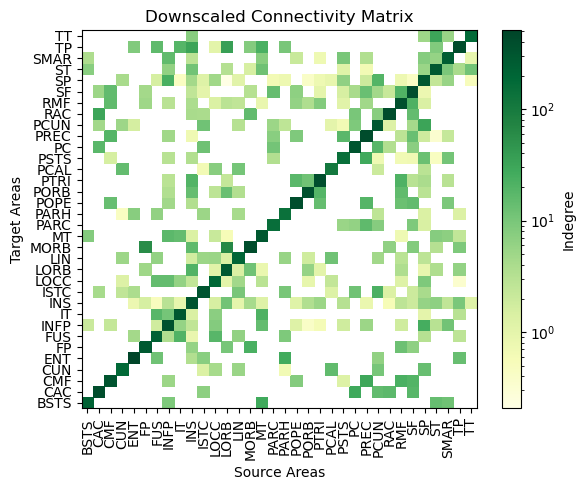

In [7]:
from humam.figures.figure_connectivity_matrices import plot_connectivity_matrices
try:
	plot_connectivity_matrices(net_dict, fullscale_NN_SN)
except NameError:
	plot_connectivity_matrices(net_dict)

Go back to [Notebook Outline](#toc)

### 2.5. Run a simulation <a class="anchor" id="section_2_5"></a>

Run the simulation, depending on the model parameter and downscale ratio, the running time varies largely.

In [8]:
# Check if the simulation has already run
if os.path.exists(os.path.join(outpath, net_hash, 'sim_hash.txt')):
	with open(os.path.join(outpath, net_hash, 'sim_hash.txt'), 'r') as f:
		sim_hash = f.read()
else:
	# Create Simulation class
	sim = humam.Simulation(sim_params, net_dict)
	# Extract the simulation dictionary
	sim.dump(net_folder)
	# Get the simulation hash
	sim_hash = sim.getHash()

	# Set output directory according to hashes
	# and run the simulation
	data_path = os.path.join(outpath, net_hash, sim_hash)
	sim.setup(data_path, num_threads)
	sim.simulate()

	# Save simulation hash to a file
	with open(os.path.join(outpath, net_hash, 'sim_hash.txt'), 'w') as f:
		f.write(sim_hash)

**Reminder**: The spike trains of simulated results are saved to the folder with path `./out/<net_hash>/<sim_hash>/spikes/`, where `<net_hash>` and `<sim_hash>` are generated in 2.2 and in this section respectively. All statistics describing network dynamics are computed from the saved spike trains.

Go back to [Notebook Outline](#toc)

## S3. Visualization of Network Dynamics <a class="anchor" id="section_3"></a>

**Important**: As cited in [Section 1.1](#11-parameters-to-tune), the `cc_scalingEtoE` parameter is critical for shifting network activity between the base and best-fit versions. In the full-scale model, setting this parameter to `1.0` produces the base activity, while `2.5` yields the best-fit activity. However, in the downscaled version, the network dynamics may differ, and these specific parameter values may not achieve the same results.

In [9]:
# Read simulation dict
sim_folder = os.path.join(outpath, net_hash, sim_hash)
sim_dict = humam.simulation.simulationDictFromDump(sim_folder)

# Create Analysis class and export it
ana = humam.Analysis(ana_params, net_dict, sim_dict, sim_folder, base_path)
ana.dump(sim_folder)

# Run the full analysis
# ana.fullAnalysis()

Results will be written to /home/spreizer/Projects/humam/human-multi-area-model/out/downscaled0.004_cc1.0/fa1092608e69a0724bb1b53d6f715a2c/570a16c38057726909803cd9f628cee4/5928ba1c4e916331236cc3caafedd3a0/plots
Plots will be written to /home/spreizer/Projects/humam/human-multi-area-model/out/downscaled0.004_cc1.0/fa1092608e69a0724bb1b53d6f715a2c/570a16c38057726909803cd9f628cee4/5928ba1c4e916331236cc3caafedd3a0/plots
11:57:53.703473 Reading popGids
_readPopGids took 0.001 s
11:57:53.704408 Reading spikes
_readSpikes took 0.212 s


### 3.1. Mean firing rate over simulated populations <a class="anchor" id="section_3_1"></a>

In [10]:
# Print the mean firing rate over simulated populations
mean_rates_per_pop = ana.meanFiringRate()
print("Average firing rate: {:.2f} spikes/s".format(mean_rates_per_pop.mean()))

meanFiringRate took 0.001 s
Average firing rate: 71.11 spikes/s


**Note**: In the downscaled model, the mean firing rate may differ from the full-scale version due to altered network dynamics. Downscaling can lead to higher firing rates and more synchronized activity. While the full-scale model typically has firing rates below 10 spikes per second, the downscaled version may exhibit higher rates due to fewer neurons and synapses and increased synaptic weights, affecting the balance.

### 3.2. Instantaneous firing rate over simulated areas <a class="anchor" id="section_3_2"></a>

firingRateHistogram took 0.014 s


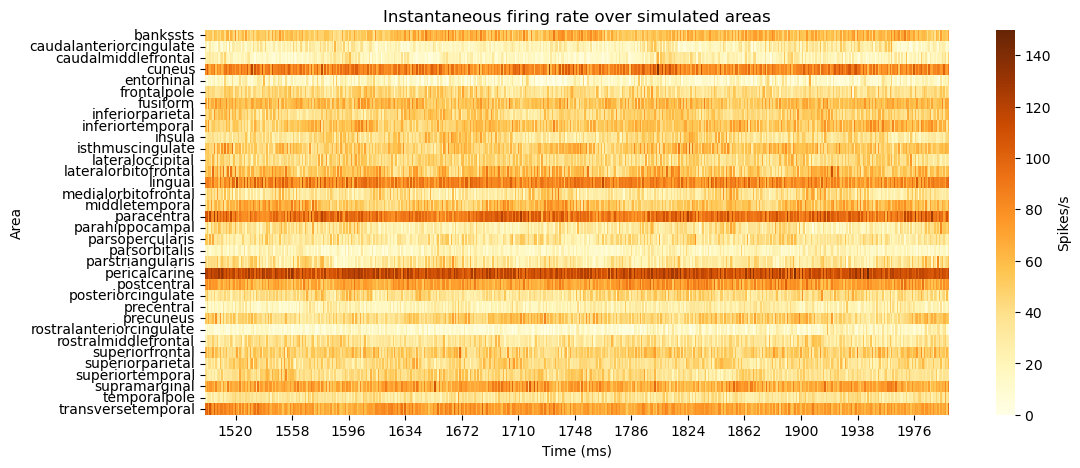

plot_instantaneous_firing_rate took 1.563 s


In [11]:
ana.plot_instantaneous_firing_rate()

### 3.3. Time-averaged firing rate over simulated populations <a class="anchor" id="section_3_3"></a>

An overview of time-averaged firing rate over simulated populations encoded in colors with areas along the horizontal axis and populations along the vertical axis. Layers that are not present in the model for specific areas are represented by the "X" mark.

meanFiringRate took 0.001 s
Total mean firing rate: 71.11 spikes/s


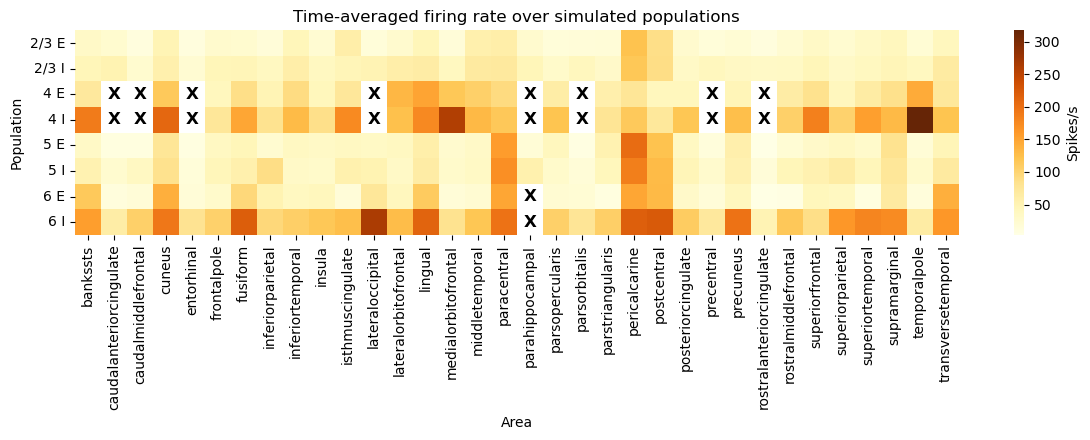

plot_average_rate_per_pop took 0.934 s


In [12]:
ana.plot_average_rate_per_pop()

### 3.4. Network dynamics <a class="anchor" id="section_3_4"></a>

Comparable figures in our publications: <br>
1. Pronold, J., Meegen, A. van, Shimoura, R. O., Vollenbröker, H., Senden, M., Hilgetag, C. C., Bakker, R., & Albada, S. J. (2024). Multi-scale spiking network model of human cerebral cortex. Cerebral Cortex. [https://doi.org/10.1093/cercor/bhae409](https://doi.org/10.1093/cercor/bhae409).<br>
   -**Fig 4.  Base version of the model.** <br>
   -**Fig 6.  Resting state of the model with $\chi = 2.5$ (best-fit state).**

In [13]:
print("Areas in the network:")
for area in ana.net_dict['area_list']:
    print(f"- {area}")

Areas in the network:
- bankssts
- caudalanteriorcingulate
- caudalmiddlefrontal
- cuneus
- entorhinal
- fusiform
- inferiorparietal
- inferiortemporal
- isthmuscingulate
- lateraloccipital
- lateralorbitofrontal
- lingual
- medialorbitofrontal
- middletemporal
- parahippocampal
- paracentral
- parsopercularis
- parsorbitalis
- parstriangularis
- pericalcarine
- postcentral
- posteriorcingulate
- precentral
- precuneus
- rostralanteriorcingulate
- rostralmiddlefrontal
- superiorfrontal
- superiorparietal
- superiortemporal
- supramarginal
- frontalpole
- temporalpole
- transversetemporal
- insula


popLv took 0.001 s
popCvIsi took 0.007 s
popCorrCoeff took 0.001 s
label: D lowest whisker: 3.3
label: D highest whisker: 264.4
label: E lowest whisker: 0.3
label: E highest whisker: 3.3


/home/spreizer/Projects/humam/human-multi-area-model/src/analysis.py:1691: UserWarning:set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/home/spreizer/Projects/humam/human-multi-area-model/src/analysis.py:1691: UserWarning:set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


label: F lowest whisker: -0.0
label: F highest whisker: 0.0
plot_raster_statistics took 1.513 s


/home/spreizer/Projects/humam/human-multi-area-model/src/analysis.py:1691: UserWarning:set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


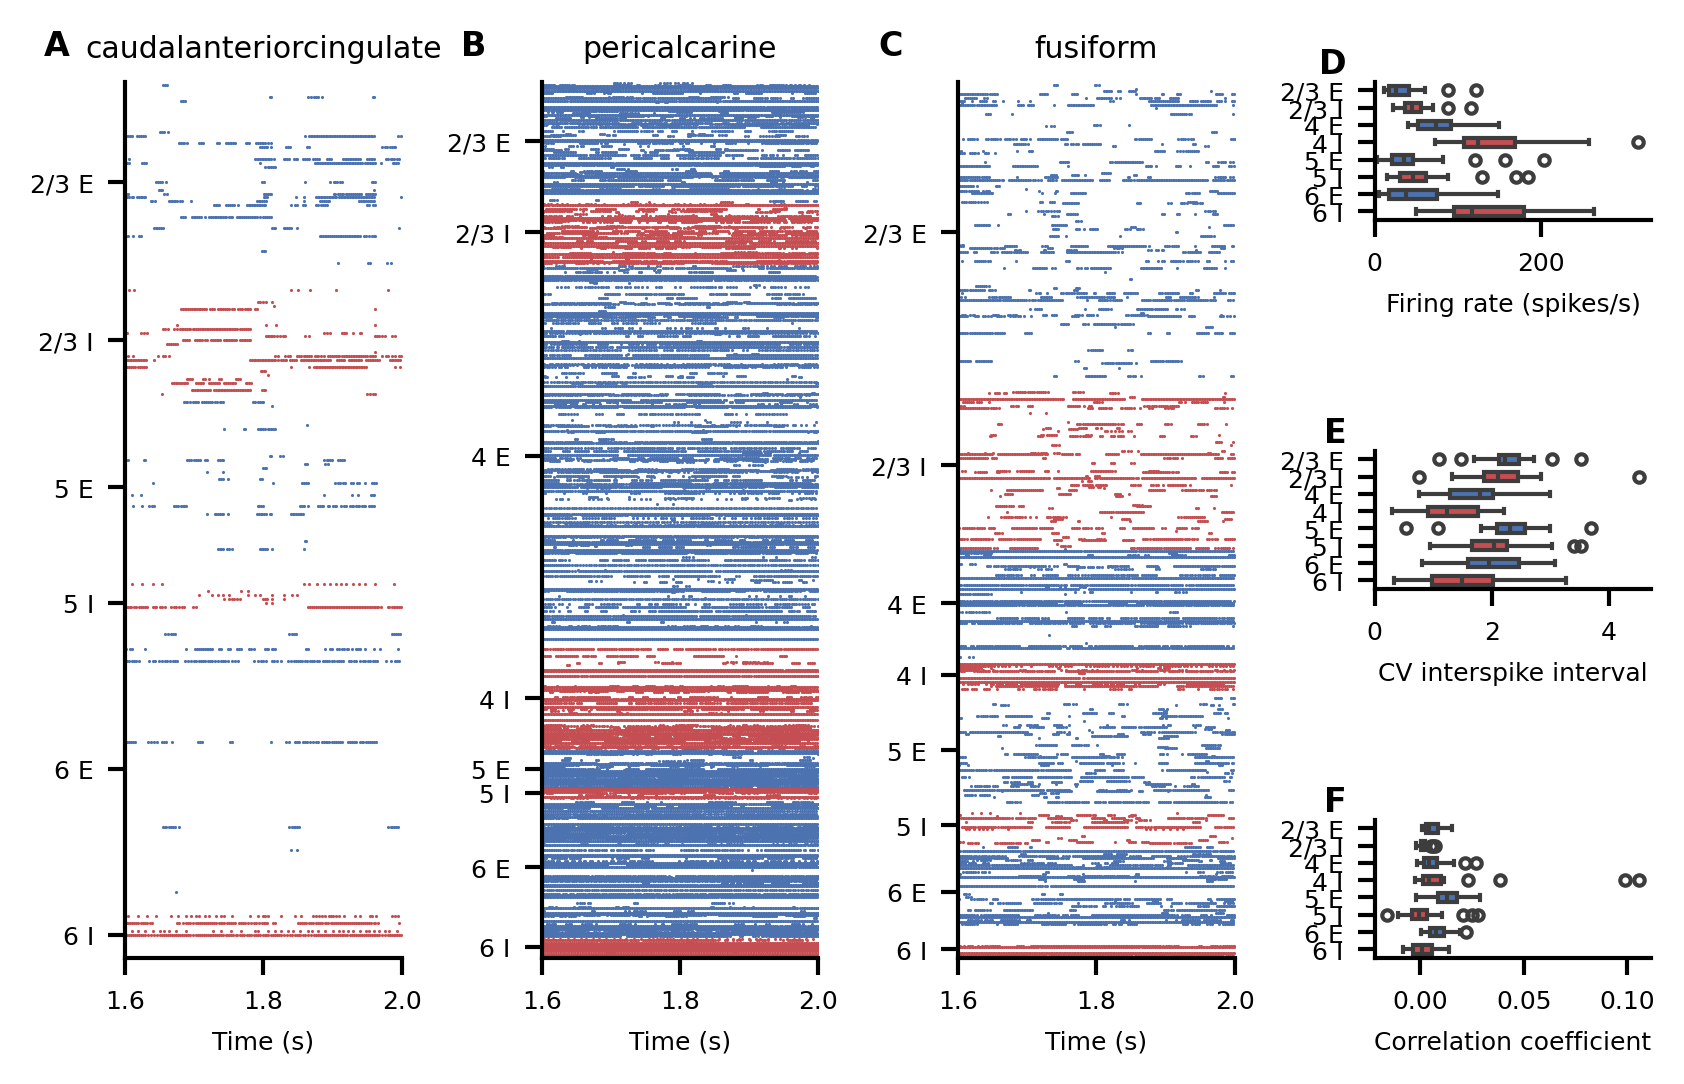

In [14]:
# Set THREE areas to plot
areas_to_plot = ['caudalanteriorcingulate', 'pericalcarine', 'fusiform']

# Plot the raster plot for the selected areas
ana.plot_raster_statistics(raster_areas=areas_to_plot)

This figure displays neural activity and statistical summaries for selected cortical areas.

Raster Plots (A, B, C): Show spiking activity in the selected areas. Each dot represents a spike, with blue for excitatory neurons and red for inhibitory neurons. The x-axis represents time (s), and the y-axis represents neuron populations.

Box Plots (D, E, F): Summarize firing rates, CV of interspike intervals, and correlation coefficients . The x-axis shows the respective measure, and the y-axis lists neuron populations. Boxes represent the interquartile range, with whiskers indicating data range within 1.5 times the interquartile range.

### 3.5. Functional connectivity <a class="anchor" id="section_3_5"></a>

Comparison of area-level functional connectivity (FC) between the down-scaled HuMAM and human experimental data. (Left) FC of human resting-state fMRI (see Materials and methods in [\[1\]](https://doi.org/10.1093/cercor/bhae409)). (Right)  Simulated FC measured by the zero-time-lag correlation coefficient of synaptic input currents

synapticInputCurrent took 0.046 s
plot_functional_connectivity took 0.42 s


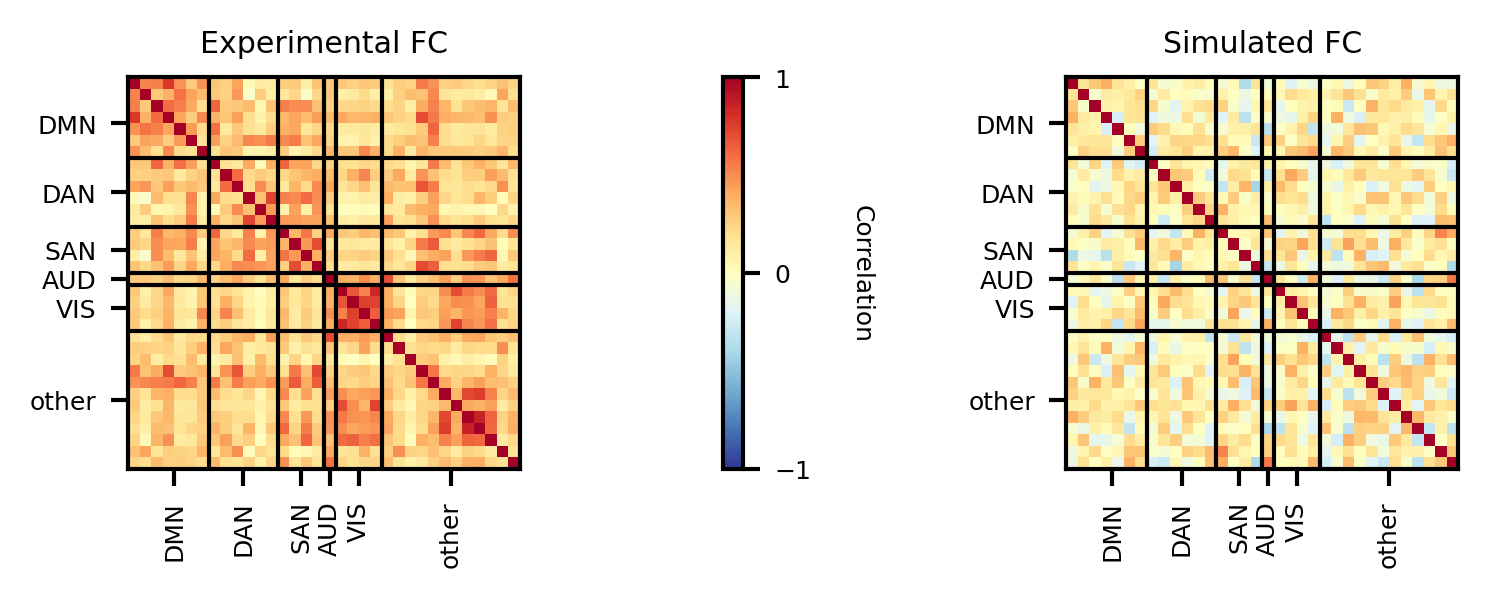

In [15]:
ana.plot_functional_connectivity()

Go back to [Notebook Outline](#toc)

## Additional Notes <a class="anchor" id="section_4"></a>

1. Simulation data <br>
The spike data of all simulated populations for all simulations are saved, by default, in `./out/<network_hash>/<simulation_hash>/spikes` where `<network_hash>` and `<simulation_hash>` can be accessed in the output of Sections [2.2](#22-generate-connectivity-matrix-and-define-neuron-numbers) and [2.5](#25-run-a-simulation) respectively.

2. Statistics <br>
The statistics of network dynamics computed from the spike trains can be found in `./out/<network_hash>/<simulation_hash>/<analysis_hash>`. You may calculate more statistics from the functions defined in `./src/analysis.py` to explore more about network dynamics.

Go back to [Notebook Outline](#toc)